# Flares in LSST Fields

*A few summary figures*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import flare_prob
import toymodel
import LSSToy

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [22]:
# let's read in the Trilegal field, and see the columns

# l=45, b=-40, fov=3.5
# file = 'trilegal_models/output164538496014.dat'

# l=45, b=-20, fov=3.5
file = 'trilegal_models/output261611164854.dat'
df = pd.read_table(file, sep=r"\s*", engine='python')
df

,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,m2/m1,mbol,u,g,r,i,z,Mact
0,1,6.65,0.13,0.04482,-2.419,3.443,4.226,8.4,0.030,0.00,19.218,27.114,23.571,21.934,20.062,18.952,0.045
1,1,6.65,0.19,0.02373,-2.711,3.396,4.053,10.6,0.037,0.00,22.147,30.728,27.437,25.823,23.582,22.099,0.024
2,1,6.65,0.31,0.27421,-2.003,3.546,5.008,13.8,0.038,0.00,23.576,28.951,26.097,24.682,23.723,23.160,0.274
3,1,6.71,-0.13,0.25839,-2.003,3.560,5.041,9.5,0.035,0.00,19.279,24.348,21.571,20.166,19.344,18.857,0.258
4,1,6.71,0.19,1.73523,0.941,3.890,4.241,9.5,0.035,0.00,11.919,13.062,11.955,11.930,12.026,12.145,1.735
5,1,6.71,0.23,0.10920,-1.872,3.482,4.222,9.5,0.035,0.80,18.351,25.322,21.995,20.405,18.885,18.000,0.109
6,1,6.71,0.25,0.07517,-2.111,3.470,4.250,8.8,0.032,0.00,18.847,26.094,22.664,21.053,19.444,18.510,0.075
7,1,6.71,0.27,0.20046,-1.955,3.510,4.620,13.3,0.038,0.87,22.517,28.465,25.460,23.978,22.806,22.116,0.174
8,1,6.77,0.33,0.08855,-2.002,3.474,4.228,11.2,0.038,0.00,20.976,28.092,24.713,23.110,21.543,20.633,0.089
9,1,6.81,-0.15,0.24271,-2.052,3.558,5.055,14.4,0.038,0.00,24.301,29.436,26.622,25.204,24.374,23.883,0.243


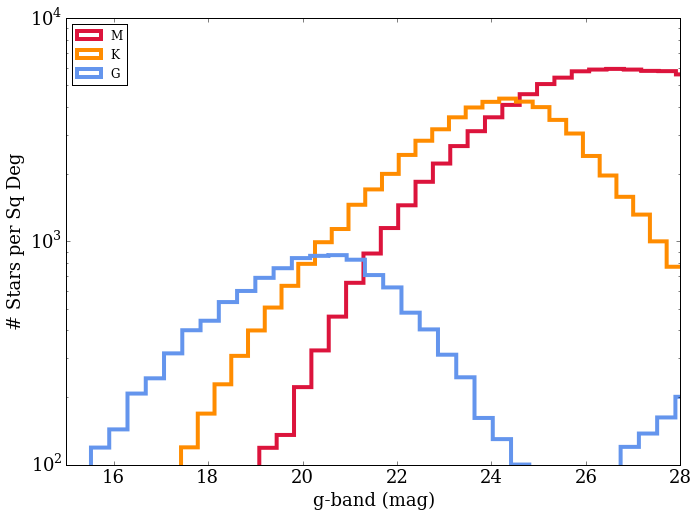

In [58]:
# make a histogram of # of stars versus Apparent Mag in each temperature bin (3k to 7k)
Teff_bins = np.log10(np.arange(3000,8000,1000))

fov = 3.5 # sq deg (size of Trilegal field)
LSSTfov = 9.6

clrs = ['crimson','darkorange','cornflowerblue']
lbl = ['M', 'K', 'G']

plt.figure(figsize=(11,8))
for k in range(len(Teff_bins)-2):
    x = np.where((df['logg'] >= 4) & (df['logTe'] >= Teff_bins[k]) & (df['logTe'] < Teff_bins[k+1]))
    _ = plt.hist(df['g'].values[x], bins=50, color=clrs[k], histtype='step', lw=4, 
                 weights=np.ones(len(x[0]))/3.5, label = lbl[k])
plt.yscale('log')
plt.xlim(15,28)
plt.ylim(1e2,1e4)
plt.xlabel('g-band (mag)')
plt.ylabel('# Stars per Sq Deg')
plt.legend(fontsize=12, loc=2)

plt.savefig('b-20_GKM.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

## Generate flares at different rates, test recovery % for LSST cadence

Only varying the $\alpha$ parameter, which controls the intercept in the Flare Frequency Distribution powerlaw. Thus we always use a fixed slope for the energy distribution, $\beta$.

In [4]:
dur = 1.0 # duration to simulate (in years)
ffd_beta = -2.0 # ffd slope
dmag_limit = -0.1 # flare detection threshold

ffd_min = 0

s_time1, s_flux1 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=1, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time2, s_flux2 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=0, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time3, s_flux3 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-1, ffd_beta=ffd_beta, ffd_min=ffd_min)

In [5]:
s_time4, s_flux4 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-2, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time5, s_flux5 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-3, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time6, s_flux6 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-4, ffd_beta=ffd_beta, ffd_min=ffd_min)

$\alpha$ = [1, 0, -1, -2, -3, -4]

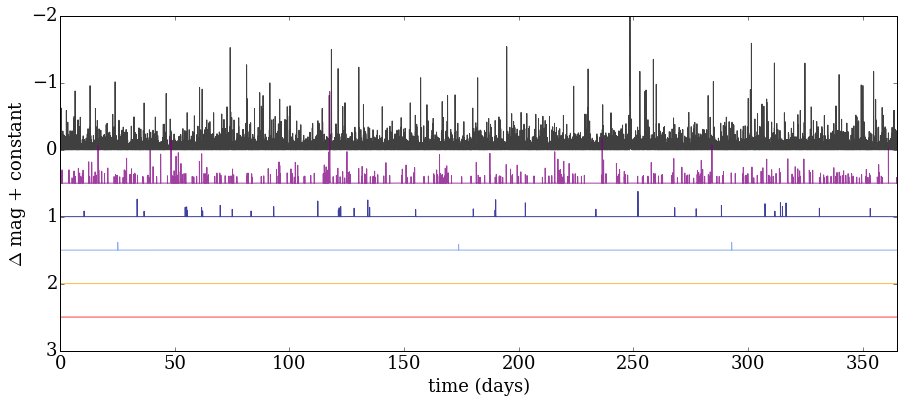

In [6]:
plt.figure(figsize=(15,6))
plt.plot(s_time1, s_flux1, alpha=0.75, c='black')
plt.plot(s_time2, s_flux2+0.5, alpha=0.75, c='purple')
plt.plot(s_time3, s_flux3+1, alpha=0.75, c='navy')
plt.plot(s_time4, s_flux4+1.5, alpha=0.75, c='cornflowerblue')
plt.plot(s_time5, s_flux5+2, alpha=0.75, c='orange')
plt.plot(s_time6, s_flux6+2.5, alpha=0.75, c='red')
plt.xlim(0, dur*365.)
plt.ylim((3,-2))
plt.xlabel('time (days)')
plt.ylabel('$\Delta$ mag + constant')

# plt.savefig('lightcurves.png', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [7]:
# ntrials = 1000

# npass1 = np.zeros(ntrials)
# npass2 = np.zeros(ntrials)
# npass3 = np.zeros(ntrials)
# npass4 = np.zeros(ntrials)
# npass5 = np.zeros(ntrials)
# npass6 = np.zeros(ntrials)


# for k in range(ntrials):
#     t,f = toymodel.downsample(s_time1, s_flux1)
#     ok = np.where((f <= dmag_limit))
#     npass1[k] = len(ok[0])
    
#     t,f = toymodel.downsample(s_time2, s_flux2)
#     ok = np.where((f <= dmag_limit))
#     npass2[k] = len(ok[0])
    
#     t,f = toymodel.downsample(s_time3, s_flux3)
#     ok = np.where((f <= dmag_limit))
#     npass3[k] = len(ok[0])
    
#     t,f = toymodel.downsample(s_time4, s_flux4)
#     ok = np.where((f <= dmag_limit))
#     npass4[k] = len(ok[0])
    
#     t,f = toymodel.downsample(s_time5, s_flux5)
#     ok = np.where((f <= dmag_limit))
#     npass5[k] = len(ok[0])
    
#     t,f = toymodel.downsample(s_time6, s_flux6)
#     ok = np.where((f <= dmag_limit))
#     npass6[k] = len(ok[0])

# plt.figure(figsize=(11,6))
# _ = plt.hist(npass1/900., histtype='step', color='black')
# _ = plt.hist(npass2/900., histtype='step', color='purple')
# _ = plt.hist(npass3/900., histtype='step', color='navy')
# _ = plt.hist(npass4/900., histtype='step', color='cyan')
# _ = plt.hist(npass5/900., histtype='step', color='orange')
# _ = plt.hist(npass6/900., histtype='step', color='red')
# plt.xlabel('Fraction of epochs with a flare')
# plt.ylabel('# of trials')
# plt.xscale('log')

In [24]:
# plt.figure(figsize=(11,6))
# plt.plot(s_flux1[np.argsort(s_flux1)][::-1] * (-1), np.linspace(0,1,len(s_flux1)), color='black')
# plt.plot(s_flux2[np.argsort(s_flux2)][::-1] * (-1), np.linspace(0,1,len(s_flux2)), color='purple')
# plt.plot(s_flux3[np.argsort(s_flux3)][::-1] * (-1), np.linspace(0,1,len(s_flux3)), color='navy')
# plt.plot(s_flux4[np.argsort(s_flux4)][::-1] * (-1), np.linspace(0,1,len(s_flux4)), color='cyan')
# plt.plot(s_flux5[np.argsort(s_flux5)][::-1] * (-1), np.linspace(0,1,len(s_flux5)), color='orange')
# plt.plot(s_flux6[np.argsort(s_flux6)][::-1] * (-1), np.linspace(0,1,len(s_flux6)), color='red')

# plt.xscale('log')
# plt.xlim(1e-4,1)
# plt.ylim(0.8,1)

# plt.ylabel('Cumulative Distribution')
# plt.xlabel('$\Delta$ Mag')

## Now sample from the actual field!

In [9]:
Age_bins = np.log10([1e5, 0.25e9, 1.5e9, 15e9]) # edges of age bins

alpha_matrix = np.array([[1, -1, -2],   # 3k-4k
                         [0, -2, -4],  # 4k-5k
                         [-1, -4, -6], # 5k-6k
                         [-4, -9, -9]]) # 6k-7k

Nstars = 50000 # how many stars to randomly sample from logg>=4, Teff<7k

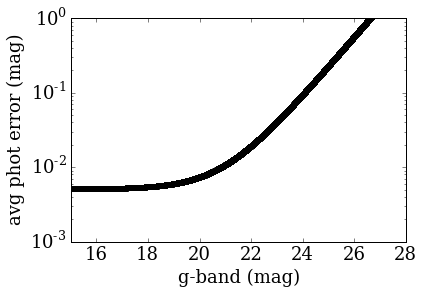

In [25]:
# find the stars to draw from
okstars = np.where((df['logg'] >= 4) & (df['logTe'] <= np.log10(7000.0)) & (df['logTe'] >= np.log10(3000.0)))

# pick random indexes to use from good stars
rr = np.array(np.floor((np.random.random(size=Nstars) * float(len(okstars[0])))), dtype=np.int)

teff = df['logTe'].values[okstars[0][rr]]
age = df['logAge'].values[okstars[0][rr]]

gmag = df['g'].values[okstars[0][rr]] # apparant g-band magnitude
gerr = LSSToy.photerror(gmag)

plt.scatter(gmag, gerr, color='k')
plt.ylim(1e-3,1)
plt.yscale('log')
plt.xlim(15,28)
plt.xlabel('g-band (mag)')
plt.ylabel('avg phot error (mag)')

# plt.savefig('error_profile.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [26]:
# Count how many flares are returned for each star
Nflares = np.zeros(Nstars)

Nflares1 = np.zeros(Nstars)
Nflares5 = np.zeros(Nstars)


# loop over all Nstars and measure flare returns!
for k in range(Nstars):
    # which are bin?
    wage = min(np.where((Age_bins >= np.float(age[k])))[0]) - 1

    # which temp bin?
    wteff = min(np.where((Teff_bins >= np.float(teff[k])))[0]) - 1

    # pick the activity level based on that
    aa = alpha_matrix[wteff, wage]

    # pick the correct flare light curve
    if aa == 1:
        tt, ff = s_time1, s_flux1
    if aa == 0:
        tt, ff = s_time2, s_flux2
    if aa == -1:
        tt, ff = s_time3, s_flux3
    if aa == -2:
        tt, ff = s_time4, s_flux4
    if aa == -4:
        tt, ff = s_time5, s_flux5
    if aa == -6:
        tt, ff = s_time6, s_flux6
    if aa < -6: # no flares
        tt, ff = s_time6, s_flux6 * 0.0
    
    # down-sample to LSST cadence
    t,f = toymodel.downsample(tt, ff)
    
    # find where LSST data >= Flare threshold (+ phot errors!)
    ok = np.where((f <= (dmag_limit - gerr[k])))
    Nflares[k] = len(ok[0])
    
    ok1 = np.where((f <= (dmag_limit - gerr[k])) & (t <= 365.*1.))
    ok5 = np.where((f <= (dmag_limit - gerr[k])) & (t <= 365.*5.))

    Nflares1[k] = len(ok1[0])
    Nflares5[k] = len(ok5[0])


(2800, 6500)

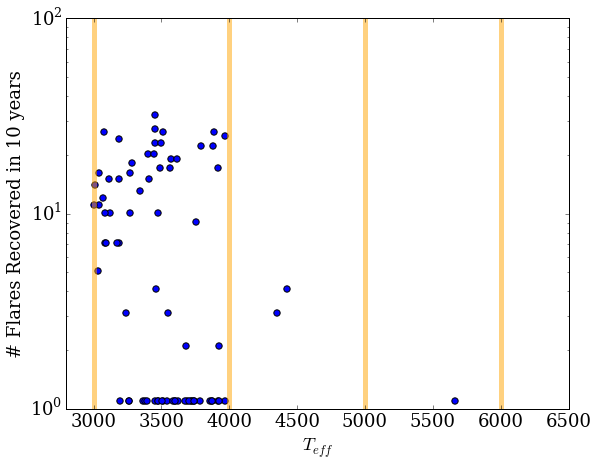

In [27]:
plt.figure(figsize=(9,7))
plt.scatter(10.**teff, Nflares + 0.1, s=40)
plt.yscale('log')
plt.xlabel('$T_{eff}$')
plt.ylabel('# Flares Recovered in 10 years')
plt.vlines(10.**Teff_bins,1,100, alpha=0.5, color='orange', lw=5)
plt.ylim(1,100)
plt.xlim(2800, 6500)

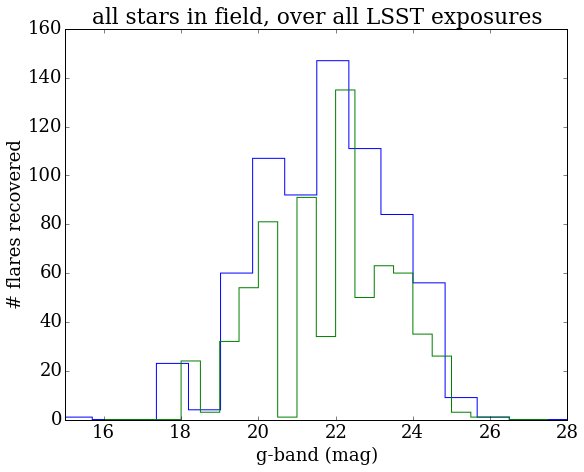

In [28]:
plt.figure(figsize=(9,7))
_ = plt.hist(gmag, weights=Nflares, bins=25, histtype='step')

gbins = np.arange(16, 28, 0.5)
_ = plt.hist(gmag, weights=Nflares, bins=gbins, histtype='step')

plt.xlim(15,28)
plt.xlabel('g-band (mag)')
plt.ylabel('# flares recovered')
plt.title('all stars in field, over all LSST exposures')

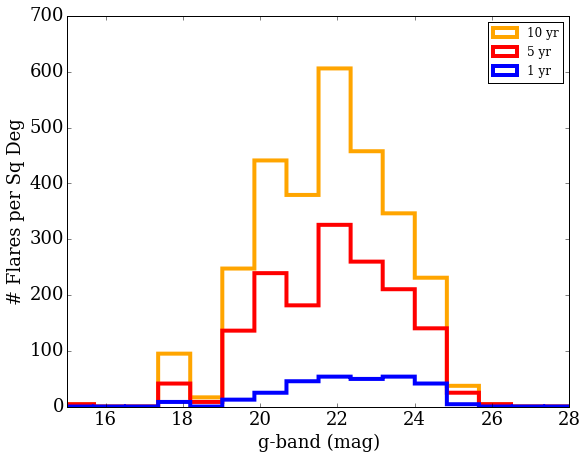

In [59]:
'''
 NOW MAKE SAME PLOT AS ABOVE BUT:
 
 - 1, 5, 10 yr yields
 - follow style of combined version later
 
'''

plt.figure(figsize=(9,7))
plt.hist(gmag, weights=Nflares * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
            bins=25, histtype='step', color='orange', lw=4, label='10 yr')
plt.hist(gmag, weights=Nflares5 * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
            bins=25, histtype='step', color='red', lw=4, label='5 yr')
plt.hist(gmag, weights=Nflares1 * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
            bins=25, histtype='step', color='blue', lw=4, label='1 yr')

plt.xlim(15,28)
# plt.yscale('log')
plt.legend(loc=0, fontsize=12)
plt.xlabel('g-band (mag)')
plt.ylabel('# Flares per Sq Deg')

plt.savefig('b-20_flareyield.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

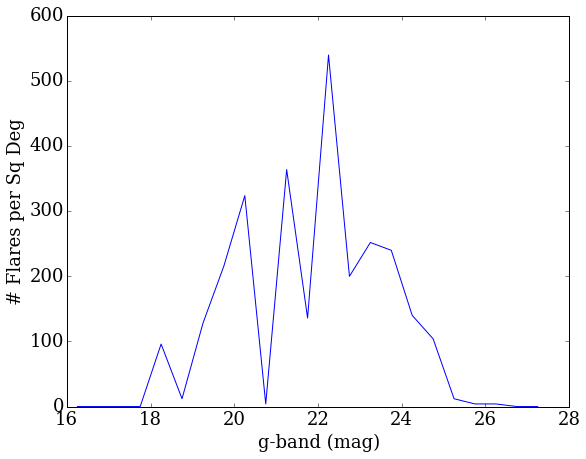

In [39]:
gbins = np.arange(16, 28, 0.5)

# all_stars, _ = np.histogram(gmag, bins=gbins)
fl_stars, _ = np.histogram(gmag, bins=gbins, weights=Nflares)

plt.figure(figsize=(9,7))
plt.plot((gbins[1:] + gbins[0:-1])/2., fl_stars * (len(df) / Nstars) / fov)
plt.xlabel('g-band (mag)')
plt.ylabel('# Flares per Sq Deg')


# Repeat Study for all Trilegal fields (a function of $b$)

Running output574523944248.dat, b=-10.0
Max distance for a flare star: 9549.92586021
Fraction of flares from M dwarfs: 0.969588550984

Running output261611164854.dat, b=-20.0
Max distance for a flare star: 4570.88189615
Fraction of flares from M dwarfs: 0.982627578719

Running output164538496014.dat, b=-40.0
Max distance for a flare star: 3019.9517204
Fraction of flares from M dwarfs: 0.993296089385

Running output208849261588.dat, b=-60.0
Max distance for a flare star: 2290.86765277
Fraction of flares from M dwarfs: 0.991758241758

Running output16533990464.dat, b=-80.0
Max distance for a flare star: 1905.46071796
Fraction of flares from M dwarfs: 0.986970684039



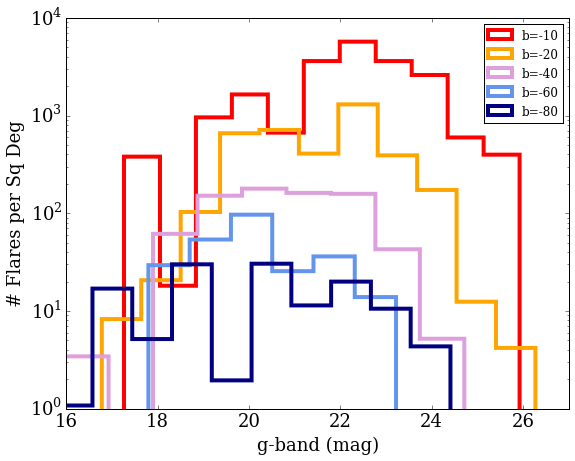

In [81]:
files, galb = np.loadtxt('trilegal_models/index.txt', comments='#', unpack=True, 
                         usecols=(0,2), dtype='str', delimiter=',')

galb = np.array(galb, dtype='float')
totflares = np.zeros(len(galb))
totstars = np.zeros(len(galb))

# arrays to compute the number of flares per sq deg as function of g-band mag
gbins = np.arange(15.25, 29, 0.5)
fl_stars = np.zeros((len(gbins)-1, len(files)), dtype='float')

clrs = ['red', 'orange', 'plum', 'cornflowerblue', 'navy']
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1)

for j in range(len(files)):
    file = 'trilegal_models/' + files[j]
    df = pd.read_table(file, sep=r"\s*", engine='python')
    
    print('Running ' + files[j] + ', b=' + str(galb[j]))
    
    # find the stars to draw from
    okstars = np.where((df['logg'] >= 4) & (df['logTe'] <= np.log10(7000.0)) & (df['logTe'] >= np.log10(3000.0)))
    # pick random indexes to use from good stars
    rr = np.array(np.floor((np.random.random(size=Nstars) * float(len(okstars[0])))), dtype=np.int)
    teff = df['logTe'].values[okstars[0][rr]]
    age = df['logAge'].values[okstars[0][rr]]
    dist = 10.**(df['m-M0'].values[okstars[0][rr]]/5. + 1.)
    gmag = df['g'].values[okstars[0][rr]] # apparant g-band magnitude
    gerr = LSSToy.photerror(gmag)

    # Count how many flares are returned for each star
    Nflares = np.zeros(Nstars)
    
    # loop over all Nstars and measure flare returns!
    for k in range(Nstars):
        # which are bin?
        wage = min(np.where((Age_bins >= np.float(age[k])))[0]) - 1

        # which temp bin?
        wteff = min(np.where((Teff_bins >= np.float(teff[k])))[0]) - 1

        # pick the activity level based on that
        aa = alpha_matrix[wteff, wage]

        # pick the correct flare light curve
        if aa == 1:
            tt, ff = s_time1, s_flux1
        if aa == 0:
            tt, ff = s_time2, s_flux2
        if aa == -1:
            tt, ff = s_time3, s_flux3
        if aa == -2:
            tt, ff = s_time4, s_flux4
        if aa == -4:
            tt, ff = s_time5, s_flux5
        if aa == -6:
            tt, ff = s_time6, s_flux6
        if aa < -6: # no flares
            tt, ff = s_time6, s_flux6 * 0.0

        # down-sample to LSST cadence
        t,f = toymodel.downsample(tt, ff)

        # find where LSST data >= Flare threshold (+ phot errors!)
        ok = np.where((f <= (dmag_limit - gerr[k])))

        Nflares[k] = len(ok[0])
    
    print('Max distance for a flare star: ' + str(max(dist[np.where((Nflares > 0))])))
    print('Fraction of flares from M dwarfs: ' + str(sum(Nflares[np.where((10.**teff <= 4000))]) / sum(Nflares)))
    print('')
    
    totflares[j] = np.sum(Nflares)
    totstars[j] = len(df)
        
    #_ = plt.hist(gmag, weights=Nflares, bins=25, histtype='step')
    
    fl_tmp, _ = np.histogram(gmag, bins=gbins, weights=Nflares)
    fl_stars[:,j] = fl_tmp
    
    #ax.plot(gbins[1:], fl_stars[:,k] * (float(totstars[k]) / float(Nstars)) / fov + 1e-5, 
    #        color=clrs[k], lw=4, ls='-', label='l='+str(int(galb[k])))
    ax.hist(gmag, weights=Nflares * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
            bins=25, histtype='step', color=clrs[j], lw=4, label='b='+str(int(galb[j])))
    
plt.xlim(16,27)
plt.ylim(1e0, 1e4)
plt.yscale('log')
plt.xlabel('g-band (mag)')
plt.ylabel('# Flares per Sq Deg')

ax.legend(loc=0, fontsize=12)
plt.savefig('flare_depth_better.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

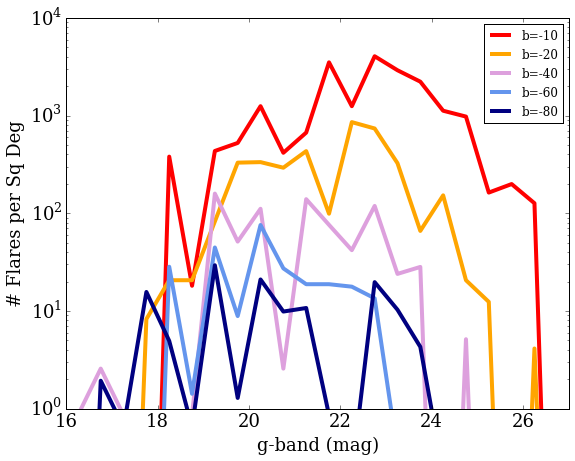

In [82]:
clrs = ['red', 'orange', 'plum', 'cornflowerblue', 'navy']
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1)

for k in range(0,len(files),1):
    ax.plot(gbins[1:], fl_stars[:,k] * (float(totstars[k]) / float(Nstars)) / fov + 1e-5, 
            color=clrs[k], lw=4, ls='-', label='b='+str(int(galb[k])))

plt.xlim(16,27)
plt.ylim(1e0, 1e4)
plt.yscale('log')
plt.xlabel('g-band (mag)')
plt.ylabel('# Flares per Sq Deg')

ax.legend(loc=0, fontsize=12)
plt.savefig('flare_depth.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [73]:
# plt.figure(figsize=(9,7))
# plt.scatter(galb, totflares / Nstars / 10, s=50)
# plt.xlabel('b, galactic latitude (deg) @ l=45')
# plt.ylabel('Total Flares per Star per year')

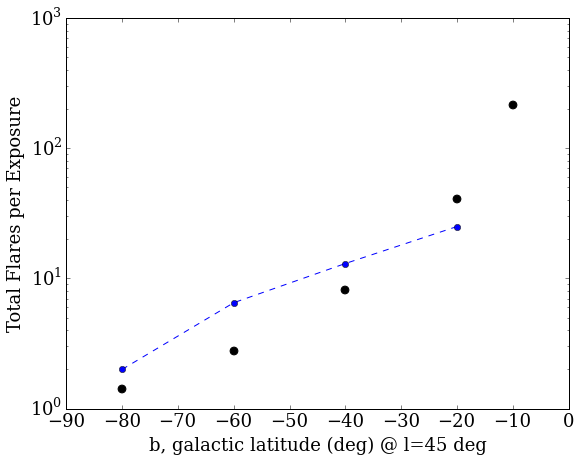

In [84]:
plt.figure(figsize=(9,7))
plt.scatter(galb, totflares / 900 * ( totstars / Nstars) * (LSSTfov / fov), s=60, c='k')
plt.xlabel('b, galactic latitude (deg) @ l=45 deg')
plt.ylabel('Total Flares per Exposure')
plt.yscale('log')

# Result from Hilton (2011) simulation at l=90
plt.plot([-20, -40, -60, -80], [25, 13, 6.5, 2],'--o')
plt.savefig('flare_b.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

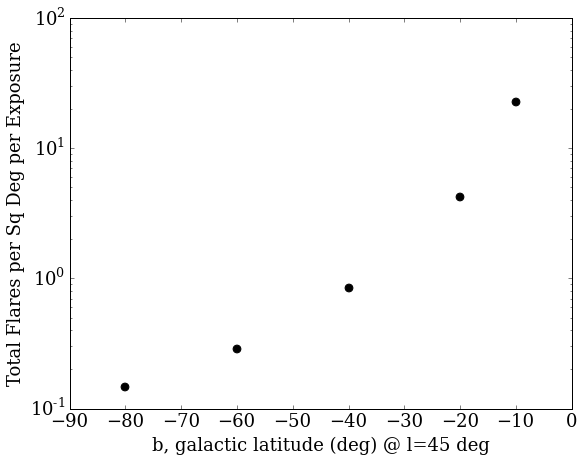

In [85]:
plt.figure(figsize=(9,7))
plt.scatter(galb, totflares / Nstars / 900 * totstars / fov, s=60, c='k')
plt.xlabel('b, galactic latitude (deg) @ l=45 deg')
plt.ylabel('Total Flares per Sq Deg per Exposure')
plt.yscale('log')
plt.savefig('flare_b_rate.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

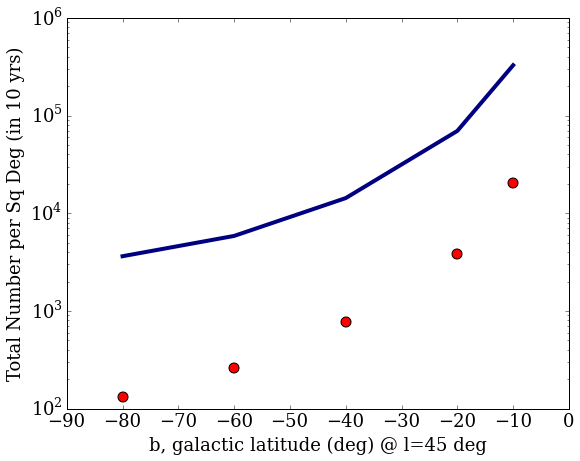

In [88]:
# rot_num = [5.42e5, 1.19e5, 2.45e4, 1.01e4, 6.17e3]
rot_num = [3.28e5, 6.97e4, 1.43e4, 5.86e3, 3.63e3]

plt.figure(figsize=(9,7))
plt.scatter(galb, totflares / Nstars * totstars / fov, s=100, c='r')

plt.plot(galb, rot_num, lw=4, color='navy')
plt.xlabel('b, galactic latitude (deg) @ l=45 deg')
# plt.ylabel('Total Flares per Sq Deg (in 10 yrs)')
plt.ylabel('Total Number per Sq Deg (in 10 yrs)')
plt.yscale('log')
plt.savefig('flare_rate_10yr.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

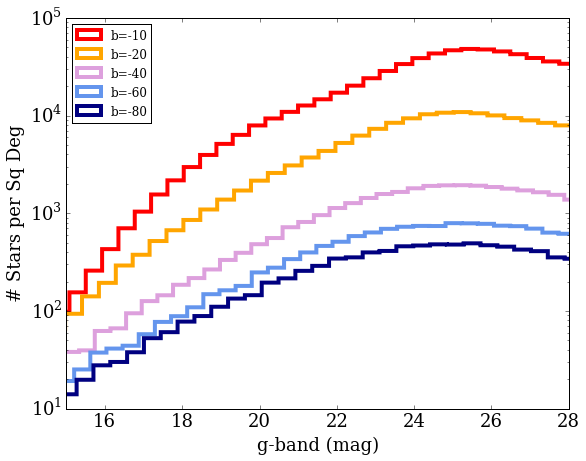

In [80]:
# make histogram of GKM stars in each field (per sq deg)

clrs = ['red', 'orange', 'plum', 'cornflowerblue', 'navy']

plt.figure(figsize=(9,7))

for j in range(len(files)):
    file = 'trilegal_models/' + files[j]
    df = pd.read_table(file, sep=r"\s*", engine='python')

    x = np.where((df['logg'] >= 4) & (df['logTe'] >= np.log10(3000)) & (df['logTe'] < np.log10(6000)))
    _ = plt.hist(df['g'].values[x], bins=50, color=clrs[j], histtype='step', lw=4, 
                 weights=np.ones(len(x[0]))/3.5, label='b='+str(int(galb[j])))
plt.yscale('log')
plt.xlim(15,28)
plt.ylim(1e1,1e5)
plt.xlabel('g-band (mag)')
plt.ylabel('# Stars per Sq Deg')
plt.legend(fontsize=12, loc=2)

plt.savefig('all_GKM.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)